In [1]:
import torch
import src
import wandb
import numpy as np
import math
import os
import cv2
import random

from PIL import Image
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [3]:
ENCODER = 'resnet152'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu') 
PARAMS = {
    "lr" : 0.00005,
    "batch_size" : 1,
    "num_splits" : 3,
}
set_random_seed(345262)

In [4]:
loss = src.utils.base.SumOfLosses(
    src.utils.losses.DiceLoss(),
    src.utils.losses.BCELoss()
)

# loss = src.utils.losses.JaccardLoss()

# loss = src.utils.losses.DiceLoss()

metrics = [
    src.utils.metrics.IoU(threshold=0.9)
]

In [5]:
# wandb.login()
# wandb.init(project="Trus_images")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dalyutkin01 (cancer_research). Use `wandb login --relogin` to force relogin


In [6]:
preprocess = src.utils.dataset.Preprocessing(
    dir='./data/',
    img_size=768,
    augmentation=False
)

In [7]:
clear_images, clear_masks = preprocess.load_folder()
kfold = KFold(n_splits=PARAMS["num_splits"], shuffle=True)
fold_data = []
for fold, (train_indices, test_indices) in enumerate(kfold.split(clear_masks)):
    train_data = {
        "images" : [clear_images[index] for index in train_indices],
        "masks" : [clear_masks[index] for index in train_indices]
    }
    test_data = {
        "images" : [clear_images[index] for index in test_indices],
        "masks" : [clear_masks[index] for index in test_indices]
    }
    fold_data.append((train_data, test_data))

# Изучение изображений

In [147]:
# from tqdm import tqdm_notebook

In [8]:
# for fold, (train_data, test_data) in enumerate(fold_data):
#     train_dataloader, valid_dataloader = preprocess.Generator(
#         batch_size=PARAMS["batch_size"],
#         X_train=train_data["images"],
#         y_train=train_data["masks"],
#         X_test=test_data["images"],
#         y_test=test_data["masks"]
#     )
#     print("Данные загружены")
#     break

Данные загружены


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


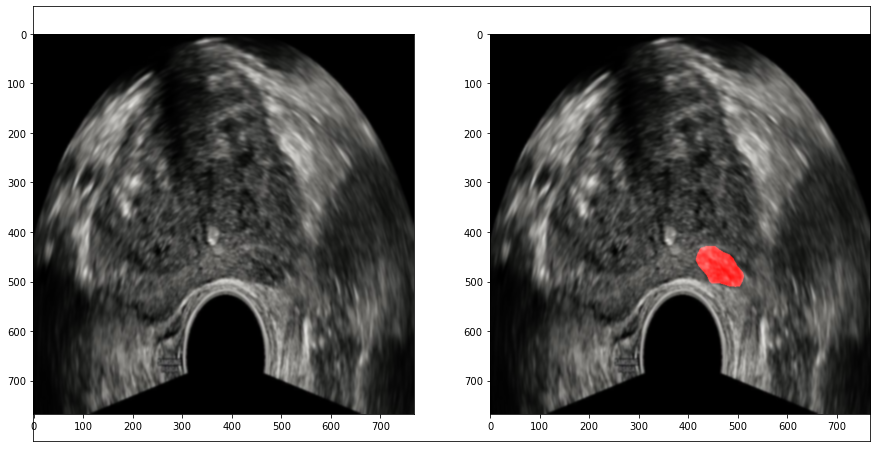

In [9]:
# fig, ax = plt.subplots(figsize=(15,8))
# image = np.moveaxis(train_dataloader.dataset.images[0], 0, -1)
# mask = train_dataloader.dataset.masks[0]

# fig.add_subplot(1,2,1)
# plt.imshow(image)
# ax.set_xticks([])
# ax.set_yticks([])

# fig.add_subplot(1,2,2)
# plt.imshow(image+cv2.merge((mask,mask,mask))*[1,0,0])
# ax.set_xticks([])
# ax.set_yticks([])
# plt.show()

In [11]:
# class anisodiff2D(object):
 
#     def __init__(self, num_iter=5, delta_t=1/7, kappa=30, option=2):
 
#         super(anisodiff2D, self).__init__()
 
#         self.num_iter = num_iter
#         self.delta_t = delta_t
#         self.kappa = kappa
#         self.option = option
 
#         self.hN = np.array([[0, 1, 0], [0, -1, 0], [0, 0, 0]])
#         self.hS = np.array([[0, 0, 0], [0, -1, 0], [0, 1, 0]])
#         self.hE = np.array([[0, 0, 0], [0, -1, 1], [0, 0, 0]])
#         self.hW = np.array([[0, 0, 0], [1, -1, 0], [0, 0, 0]])
#         self.hNE = np.array([[0, 0, 1], [0, -1, 0], [0, 0, 0]])
#         self.hSE = np.array([[0, 0, 0], [0, -1, 0], [0, 0, 1]])
#         self.hSW = np.array([[0, 0, 0], [0, -1, 0], [1, 0, 0]])
#         self.hNW = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]])
 
#     def fit(self, img):
 
#         diff_im = img.copy()
 
#         dx = 1; dy = 1; dd = math.sqrt(2)
 
#         for i in range(self.num_iter):
#             nablaN = cv2.filter2D(diff_im, -1, self.hN)
#             nablaS = cv2.filter2D(diff_im, -1, self.hS)
#             nablaW = cv2.filter2D(diff_im, -1, self.hW)
#             nablaE = cv2.filter2D(diff_im, -1, self.hE)
#             nablaNE = cv2.filter2D(diff_im, -1, self.hNE)
#             nablaSE = cv2.filter2D(diff_im, -1, self.hSE)
#             nablaSW = cv2.filter2D(diff_im, -1, self.hSW)
#             nablaNW = cv2.filter2D(diff_im, -1, self.hNW)
 
#             cN = 0; cS = 0; cW = 0; cE = 0; cNE = 0; cSE = 0; cSW = 0; cNW = 0
 
#             if self.option == 1:
#                 cN = np.exp(-(nablaN/self.kappa)**2)
#                 cS = np.exp(-(nablaS/self.kappa)**2)
#                 cW = np.exp(-(nablaW/self.kappa)**2)
#                 cE = np.exp(-(nablaE/self.kappa)**2)
#                 cNE = np.exp(-(nablaNE/self.kappa)**2)
#                 cSE = np.exp(-(nablaSE/self.kappa)**2)
#                 cSW = np.exp(-(nablaSW/self.kappa)**2)
#                 cNW = np.exp(-(nablaNW/self.kappa)**2)
#             elif self.option == 2:
#                 cN = 1/(1+(nablaN/self.kappa)**2)
#                 cS = 1/(1+(nablaS/self.kappa)**2)
#                 cW = 1/(1+(nablaW/self.kappa)**2)
#                 cE = 1/(1+(nablaE/self.kappa)**2)
#                 cNE = 1/(1+(nablaNE/self.kappa)**2)
#                 cSE = 1/(1+(nablaSE/self.kappa)**2)
#                 cSW = 1/(1+(nablaSW/self.kappa)**2)
#                 cNW = 1/(1+(nablaNW/self.kappa)**2)
 
#             diff_im = diff_im + self.delta_t * (
 
#                 (1/dy**2)*cN*nablaN +
#                 (1/dy**2)*cS*nablaS +
#                 (1/dx**2)*cW*nablaW +
#                 (1/dx**2)*cE*nablaE +
 
#                 (1/dd**2)*cNE*nablaNE +
#                 (1/dd**2)*cSE*nablaSE +
#                 (1/dd**2)*cSW*nablaSW +
#                 (1/dd**2)*cNW*nablaNW
#             )
 
#         return diff_im

In [230]:
# from scipy import optimize

# def convex_non_quadratic_variation_restoration(image, sigma, alpha, beta, gamma, tol=1e-3):
#     """
#     Performs convex non-quadratic variation restoration on an input image.

#     Args:
#         image (ndarray): Input image as a numpy array.
#         alpha (float): Regularization parameter.
#         max_iter (int): Maximum number of iterations for optimization. Default is 100.
#         tol (float): Tolerance for optimization. Default is 1e-3.

#     Returns:
#         ndarray: The restored image.
#     """
#     image_shape = image.shape
#     image = image.flatten()
    
#     # Define the objective function and its gradient
#     def objective_function(x):
#         x = x.reshape(image_shape)
#         grad = np.gradient(x)
#         tv_norm = np.sqrt(grad[0] ** 2 + grad[1] ** 2)
#         speckle_term = np.log(1 + x ** 2 / beta ** 2) / (2 * np.log(1 + 1 / beta ** 2))
#         return 0.5 * np.sum((x.flatten() - image) ** 2 / sigma ** 2) + alpha * np.sum(tv_norm) + gamma * np.sum(speckle_term)

#     def gradient_function(x):
#         x = x.reshape(image_shape)
#         grad = np.gradient(x)
        
#         speckle_term = x / (x ** 2 + beta ** 2)
#         tv_norm = np.sqrt(grad[0] ** 2 + grad[1] ** 2)

#         gradient = (x - image.reshape(image_shape)).flatten()/ sigma ** 2
#         tv_grad_x, tv_grad_y = np.gradient(tv_norm)

#         gradient += alpha * (grad[0] / tv_norm * tv_grad_x + 
#                                 grad[1] / tv_norm * tv_grad_y).flatten()
#         gradient += gamma * speckle_term.flatten()
#         return gradient
    
#     # Initialize variables
#     x = image.copy()
#     fval = objective_function(x)
    
#     # Optimize using L-BFGS
#     x, fval, _ = optimize.fmin_l_bfgs_b(objective_function, x, fprime=gradient_function, factr=tol)
        
#     # Reshape the output to match the input shape
#     x = x.reshape(image_shape)
        
#     return x


In [229]:
# import matplotlib.pyplot as plt
# from skimage import data, img_as_float

# # Load input image
# image = img_as_float(data.camera())

# # Add noise to the image
# np.random.seed(0)
# noisy_image = image + 0.5 * np.random.randn(*image.shape)

# # Restore the image using convex non-quadratic variation restoration
# sigma = 8
# alpha = 2
# beta = 0.5
# gamma = 3
# restored_image = convex_non_quadratic_variation_restoration(noisy_image, sigma, alpha, beta, gamma,max_iter=1)

# # Display the original, noisy, and restored images
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
# ax[0].imshow(image, cmap='gray')
# ax[0].set_title('Original')
# ax[0].axis('off')
# ax[1].imshow(noisy_image, cmap='gray')
# ax[1].set_title('Noisy')
# ax[1].axis('off')
# ax[2].imshow(restored_image, cmap='gray')
# ax[2].set_title('Restored')
# ax[2].axis('off')
# plt.show()

Training on fold 1...

Epoch: 1
valid: 100%|██████████| 34/34 [00:13<00:00,  2.53it/s, dice_loss + bce_loss - 1.411, iou_score - 0.3012]
Model saved!

Epoch: 2
valid: 100%|██████████| 34/34 [00:13<00:00,  2.52it/s, dice_loss + bce_loss - 1.339, iou_score - 0.357] 
Model saved!

Epoch: 3
valid: 100%|██████████| 34/34 [00:13<00:00,  2.50it/s, dice_loss + bce_loss - 1.253, iou_score - 0.3621]
Model saved!

Epoch: 4
valid: 100%|██████████| 34/34 [00:13<00:00,  2.55it/s, dice_loss + bce_loss - 1.231, iou_score - 0.3604]

Epoch: 5
valid: 100%|██████████| 34/34 [00:13<00:00,  2.52it/s, dice_loss + bce_loss - 1.15, iou_score - 0.3883] 
Model saved!
Training on fold 2...

Epoch: 1
valid: 100%|██████████| 34/34 [00:13<00:00,  2.50it/s, dice_loss + bce_loss - 1.1, iou_score - 0.07533]  

Epoch: 2
valid: 100%|██████████| 34/34 [00:13<00:00,  2.47it/s, dice_loss + bce_loss - 0.9952, iou_score - 0.3503]

Epoch: 3
valid: 100%|██████████| 34/34 [00:13<00:00,  2.53it/s, dice_loss + bce_loss - 0.9386, i

  0%|          | 0/1 [00:00<?, ?it/s]

fold_1/train/train_IoU,▁▄▆▇█
fold_1/train/train_loss,█▅▃▂▁
fold_1/valid/valid_IoU,▁▅▆▆█
fold_1/valid/valid_loss,█▆▄▃▁
fold_2/train/train_IoU,▁▄▇▇█
fold_2/train/train_loss,█▆▄▂▁
fold_2/valid/valid_IoU,▁▆▇█▅
fold_2/valid/valid_loss,█▅▃▁▂
fold_3/train/train_IoU,▁▄▆▇█
fold_3/train/train_loss,█▄▃▂▁
fold_3/valid/valid_IoU,▁▇▇█▇


In [262]:
# image = np.array(fold_data[0][0]['images'][1])
# mask = fold_data[0][0]['masks'][1]

# image = anisodiff2D().fit(img=image)
# # image = convex_non_quadratic_variation_restoration(image, 0.1)

# b, g, r = cv2.split(image)
# image_3d = cv2.merge([b, g, r])
# image_3d = (255 - image_3d)
# image = (cv2.resize(
#             image_3d, 
#             (768, 768),
#             interpolation = cv2.INTER_AREA)
# ).astype('float32')/255
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         # image = cv2.GaussianBlur(image,(3,3),cv2.BORDER_DEFAULT)
# # image = (np.rint(image)).astype(np.uint8)
# sigma = 4
# alpha = 2
# beta = 0.1
# gamma = 2
# # image[:,:,0] = convex_non_quadratic_variation_restoration(image[:,:,0], sigma, alpha, beta, gamma)
# # image[:,:,1] = convex_non_quadratic_variation_restoration(image[:,:,1], sigma, alpha, beta, gamma)
# # image[:,:,2] = convex_non_quadratic_variation_restoration(image[:,:,2], sigma, alpha, beta, gamma)
# image = convex_non_quadratic_variation_restoration(image, sigma, alpha, beta, gamma)
# mask = (cv2.resize(
#                     mask, 
#                     (768, 768),
#                     interpolation = cv2.INTER_AREA)
#                 ).astype('float32')
                
# mask = mask.max(axis=2)/255
# # mask = cv2.merge((mask,mask,mask))

<ipython-input-230-fa57e5734b0e>:37: RuntimeWarning: invalid value encountered in true_divide
  gradient += alpha * (grad[0] / tv_norm * tv_grad_x +
<ipython-input-230-fa57e5734b0e>:38: RuntimeWarning: invalid value encountered in true_divide
  grad[1] / tv_norm * tv_grad_y).flatten()


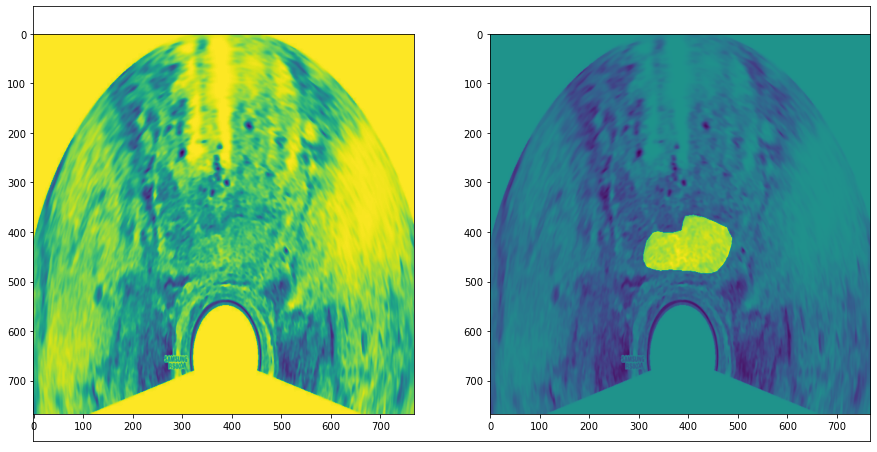

In [263]:
# fig, ax = plt.subplots(figsize=(15,8))

# fig.add_subplot(1,2,1)
# plt.imshow(image)
# ax.set_xticks([])
# ax.set_yticks([])

# fig.add_subplot(1,2,2)
# plt.imshow(image+mask)
# ax.set_xticks([])
# ax.set_yticks([])
# plt.show()

In [43]:
# fig = plt.figure(figsize=(10,8))
# plt.imshow(fold_data[0][0]['images'][0]+fold_data[0][0]['masks'][0]*[100,0,0])
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 720x576 with 1 Axes>

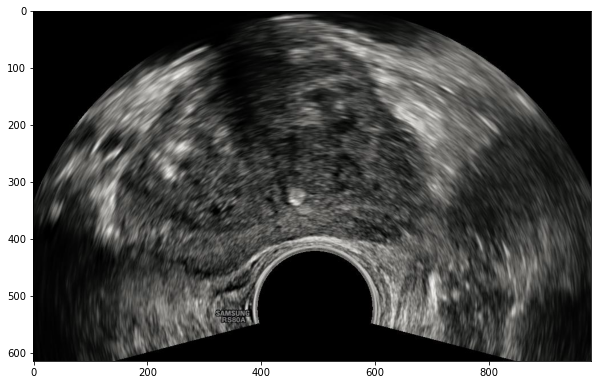

In [44]:
# fig = plt.figure(figsize=(10,8))
# plt.imshow(fold_data[0][0]['images'][0])
# plt.show()

In [75]:
# item = fold_data[0][1]['images'][0]/255

In [83]:
# anisodiff2D().fit(img=item).shape

(615, 980, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


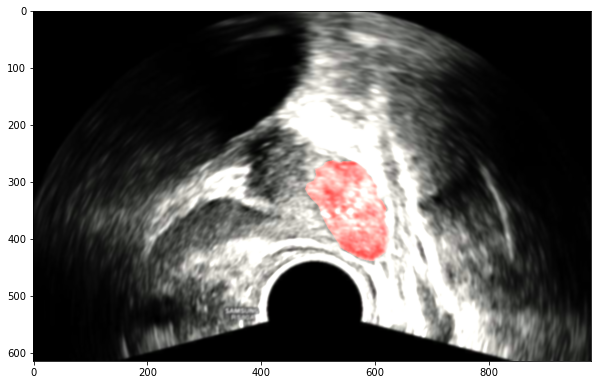

In [80]:
# fig = plt.figure(figsize=(10,8))
# plt.imshow(anisodiff2D().fit(img=item)+fold_data[0][1]['masks'][0]*[1,0,0])
# plt.show()

In [79]:
# fig = plt.figure(figsize=(10,8))
# plt.imshow(anisodiff2D().fit(img=item))
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 720x576 with 1 Axes>

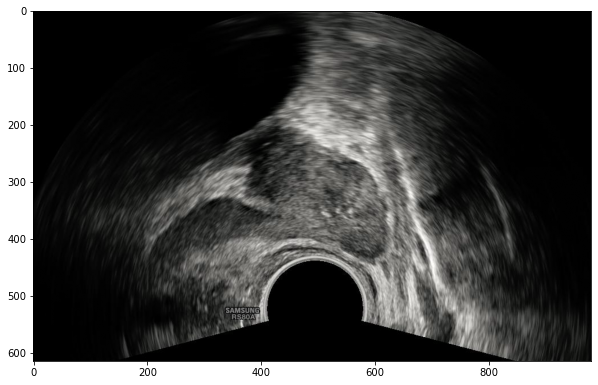

In [81]:
# fig = plt.figure(figsize=(10,8))
# plt.imshow(item)
# plt.show()

# Learning

In [8]:
# import matplotlib.pyplot as plt
# img = clear_images[1]
# # cv2.imshow("original", img)
 
# # Display cropped image
# b, g, r = cv2.split(img)
# np.multiply(b, 1.4, out=b, casting="unsafe")
# np.multiply(g, 1.7, out=g, casting="unsafe")
# np.multiply(r, 3, out=r, casting="unsafe")

# after = cv2.merge([b, g, r])

# cv2.imshow('before', img)
# cv2.imshow('after', after)
# cv2.waitKey()

In [9]:
# img = preprocess.prepocessing_image(clear_images[0])
# img.sum()
# cv2.imshow('after', img)
# cv2.waitKey()

In [11]:
track = 0
TEST_IMAGES = 0
TEST_MASKS = 0
loader_for_top_model = 0
for fold, (train_data, test_data) in enumerate(fold_data):
    print(f"Training on fold {fold + 1}...")
    model = src.UnetPlusPlus(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=3,
        classes=1,
        activation=ACTIVATION,
    )
    optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=PARAMS["lr"]),])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
        factor=0.1, patience=1, threshold=0.0001, threshold_mode='abs')
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.02)
    train_epoch = src.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )
    valid_epoch = src.utils.train.ValidEpoch(
        model,
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )
    
    train_dataloader, valid_dataloader = preprocess.Generator(
        batch_size=PARAMS["batch_size"],
        X_train=train_data["images"],
        y_train=train_data["masks"],
        X_test=test_data["images"],
        y_test=test_data["masks"]
    )

    for epoch in range(0, 5):
        print('\nEpoch: {}'.format(epoch + 1))
        train_logs = train_epoch.run(train_dataloader)
        valid_logs = valid_epoch.run(valid_dataloader)
        
        wandb.log({
            f'fold_{fold+1}/train/train_IoU': train_logs['iou_score'],
            f'fold_{fold+1}/train/train_loss': train_logs['dice_loss + bce_loss']
        })
        wandb.log({
            f'fold_{fold+1}/valid/valid_IoU': valid_logs['iou_score'], 
            f'fold_{fold+1}/valid/valid_loss': valid_logs['dice_loss + bce_loss']
        })
        
        scheduler.step(valid_logs['dice_loss + bce_loss'])
        if track < valid_logs['iou_score']:
            TEST_IMAGES = test_data["images"]
            TEST_MASKS = test_data["masks"]
            track = valid_logs['iou_score']
            loader_for_top_model = test_data
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_IoU' : track
                }, f'./checkpoint/best_model_{PARAMS["num_splits"]}fold.pth')
            print('Model saved!')
wandb.finish()

Training on fold 1...

Epoch: 1
train:   0%|          | 0/68 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [10]:
valid_pred_folder = './valid_predict_kfold_v1/'
checkpoint = torch.load(f'./checkpoint/best_model_{PARAMS["num_splits"]}fold.pth')
model.load_state_dict(checkpoint['model_state_dict'])
checkpoint['best_IoU']

0.4676332465001406

In [11]:
preds = []
for image in TEST_IMAGES:
    image_prepoc = preprocess.inference_image(image)
    image_prepoc = torch.tensor(np.array([image_prepoc]), dtype = torch.float)
    image_prepoc = image_prepoc.to(DEVICE)
    with torch.no_grad():
        predict = model.forward(image_prepoc)
    predict_value = predict.cpu().detach().numpy()
    preds.append(predict_value)

In [12]:
def test(number):
    test = cv2.resize(
        TEST_MASKS[number],
        (768, 768),
        interpolation = cv2.INTER_AREA
    ).astype('float32')
    return float(metrics[0](torch.tensor(test), torch.tensor(preds[number][0][0])))

In [13]:
test_list = []
for i in range(len(TEST_MASKS)):
    test_list.append(test(i))
print(sum(test_list) / len(test_list))

0.023302702972774997


In [14]:
for num in range(len(TEST_IMAGES)):
    true_mask = TEST_MASKS[num]
    true_mask = cv2.cvtColor(true_mask, cv2.COLOR_BGR2RGB)
    greenBGR = src.utils.plotting.Visual.green_chanel(true_mask)
    concat_true = cv2.addWeighted(TEST_IMAGES[num], 0.4, true_mask, 0.9, 0)
    
    #preproc predict
    predict_mask = src.utils.plotting.Visual.preproc_predict(preds[num])
    blueBGR_predict = src.utils.plotting.Visual.blue_chanel_predict(predict_mask)
    greenBGR_predict = src.utils.plotting.Visual.green_chanel_predict(predict_mask)
    
    #calc IoU
    IoU = src.utils.plotting.Visual.calc_IoU(greenBGR, greenBGR_predict)
    
    #concat two masks
    bitwiseAnd = cv2.bitwise_or(greenBGR, blueBGR_predict)
    
    #concat true images with mask
    concat_predict = cv2.addWeighted(TEST_IMAGES[num], 0.7, bitwiseAnd, 0.7, 0)
    concat_predict_resize = cv2.resize(concat_predict, (1280, 872), interpolation = cv2.INTER_AREA)
    
    #put text
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (570, 50)
    fontScale = 1
    color = (0, 255, 255)
    thickness = 2
    image = cv2.putText(concat_predict_resize, 'IoU ' + str(round(IoU, 3)), org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
    
    #save 
    cv2.imwrite(filename=os.path.join(valid_pred_folder + str(num) + "_true" + '.png'), img=concat_true)
    cv2.imwrite(filename=os.path.join(valid_pred_folder + str(num) + "_predict" + '.png'), img=concat_predict_resize)

In [16]:
x = torch.randn(1, 3, 768, 768, requires_grad=True)
model.to('cpu')
model.eval()
torch.onnx.export(
    model, x, "UNET++_trained.onnx", 
    export_params=True, 
    verbose=True,
    input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(20)],
    output_names = [ "output1" ])

c:\Users\Dmitry\Desktop\code\analysis_trus_images\src\base\model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:
